# Содержание <a id='Content'></a>

[Описание проекта](#Task_description)   
    [Описание данных проекта](#Data_description)     

1. [Подготовка данных](#1)    

2. [Анализ](#2)    

3. [Обучение](#3)     
    3.1 [Подготовка признаков](#3.1)     
    3.2 [Разбивка на обучающую и тестовую выборки](#3.2)     
    3.3 [Выбор метрик для оценки](#3.3)     
    3.4 [Подготовка наборов данных к кросс-валидации ](#3.4)     
    3.5 [Подготовка моделей](#3.5)     

4. [Выводы](#4)    

[Чек-лист проверки](#Check_list)    
[Записи для себя](#For_myself)

## [Описание проекта](#Content) <a id='Task_description'></a>

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### [Описание данных](#Content) <a id='Data_description'></a>

Данные лежат в файле [`taxi.csv`] (`/datasets/taxi.csv`). 
- Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).



In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# 1. [Подготовка](#Content) <a id='1'></a>

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
taxi = pd.read_csv(r'/datasets/taxi.csv',parse_dates=[0], index_col = [0])
taxi

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Открыли.

In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Посмотрели:
- можно уменьшить расход памяти для колонки числа заказов

In [6]:
taxi['num_orders'] = pd.to_numeric(taxi['num_orders'], downcast = 'integer')

In [7]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int8
dtypes: int8(1)
memory usage: 232.9 KB


Проверим также:
- Дубликаты
- Интервал между значениями ряда (сбит или нет)

In [8]:
taxi.index.duplicated().sum()

0

Проверяем интервал времени:

In [9]:
(pd.DataFrame(taxi.index).shift(periods = 1) - pd.DataFrame(taxi.index))['datetime'].unique()

array([        'NaT', -600000000000], dtype='timedelta64[ns]')

Сбитых интревалов и дубликатов во времени нет

Следующие шаги: 
- Ресемплирование
    Нам нет смысла контролировать число заказов каждые 10 секунд. все равно время реакции водителя 1-2 минуты на "принять заказ" и 5-7 минут подъехать. Увеличим таймфрейм до часа (согласно заданию). 

In [10]:
taxi_resampled = taxi.resample('1H').sum()
taxi_resampled

,num_orders
datetime,
2018-03-01 00:00:00,124.0
2018-03-01 01:00:00,85.0
2018-03-01 02:00:00,71.0
2018-03-01 03:00:00,66.0
2018-03-01 04:00:00,43.0
...,...
2018-08-31 19:00:00,136.0
2018-08-31 20:00:00,154.0
2018-08-31 21:00:00,159.0


In [11]:
taxi = taxi.asfreq('H')
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int8
dtypes: int8(1)
memory usage: 38.8 KB


Ресемплирование выполнено

# 2. [Анализ](#Content) <a id='2'></a>

In [12]:
def get_time_info(df):
    plt.figure(figsize=(20,5))    
    ax = sns.violinplot(x=df['num_orders'],  inner="quartile")
    ax.set_xlabel('Число заказов')
    plt.figure(figsize=(20,10))
    ax2 = sns.lineplot(data=df['num_orders'].iloc[0:1000], linewidth=1.5)
    ax2.set_xlabel('Время')
    ax2.set_ylabel('Число заказов')
    display(df['num_orders'].describe())

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


count    4416.000000
mean       14.502038
std         9.280162
min         0.000000
25%         8.000000
50%        13.000000
75%        19.000000
max        98.000000
Name: num_orders, dtype: float64

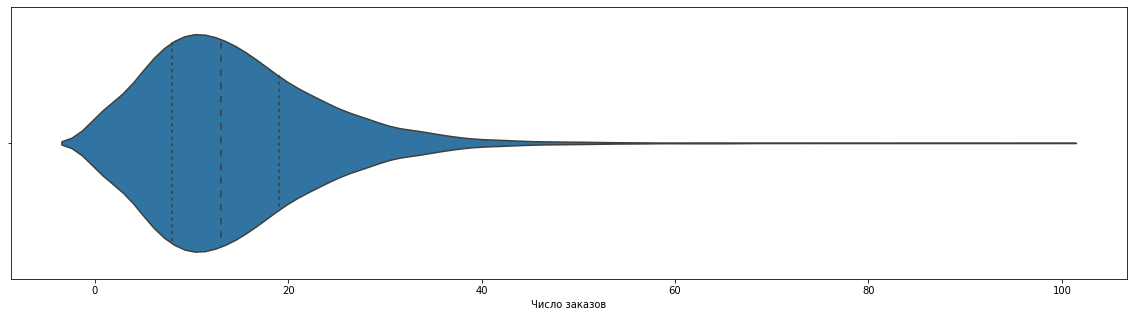

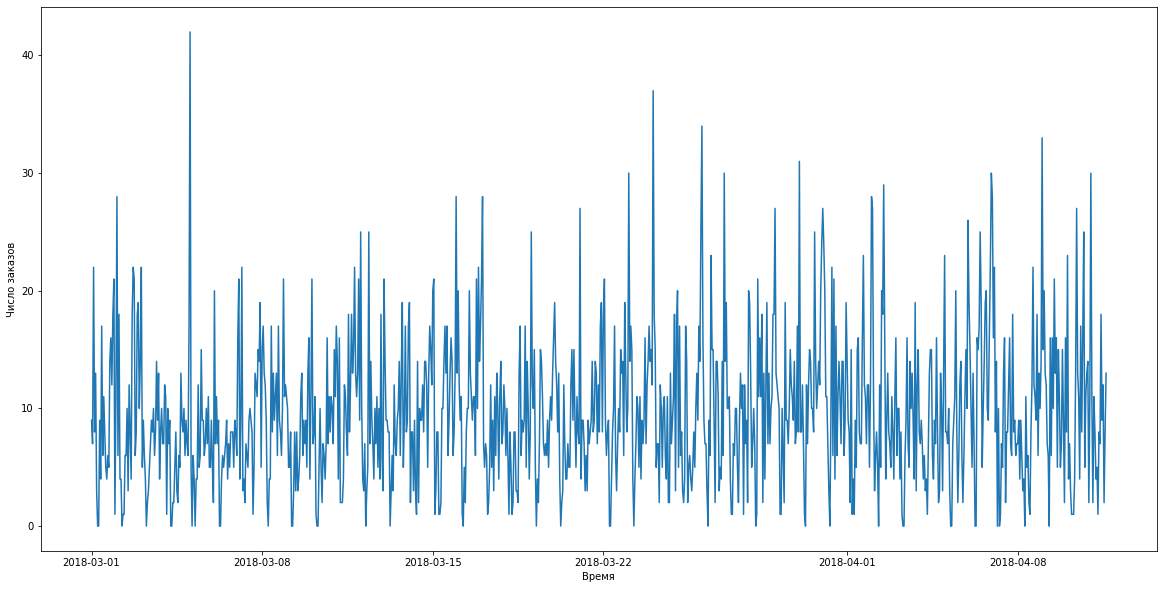

In [13]:
get_time_info(taxi)

Чудесный датафрейм! Все бы были такими! 

Есть конечно отдельные выбросы (violinplot), но я не буду уделять им внимание - ведь далее мы будем усреднять значения и делать скользящие при подготовке признаков.. 

Посмотрим на сам график числа вызовов такси. Такая гребенка нам не подходит

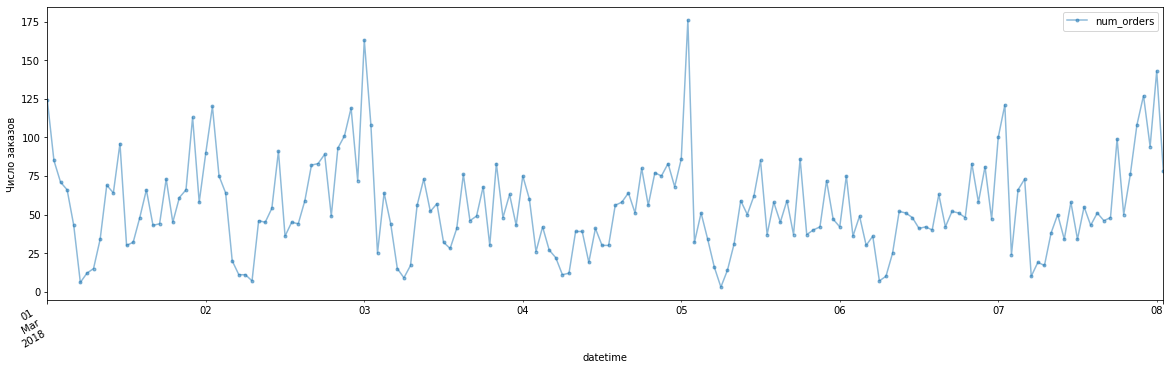

In [14]:
axes = taxi_resampled[0:170].plot(marker = '.',alpha=0.5,linestyle=None, figsize = (20,6), subplots= True)
for ax in axes:
    ax.set_ylabel('Число заказов')

Уже явно прослеживается сезонность на ресемплированном датафрейме

Присутствует недельная и суточная периодичность

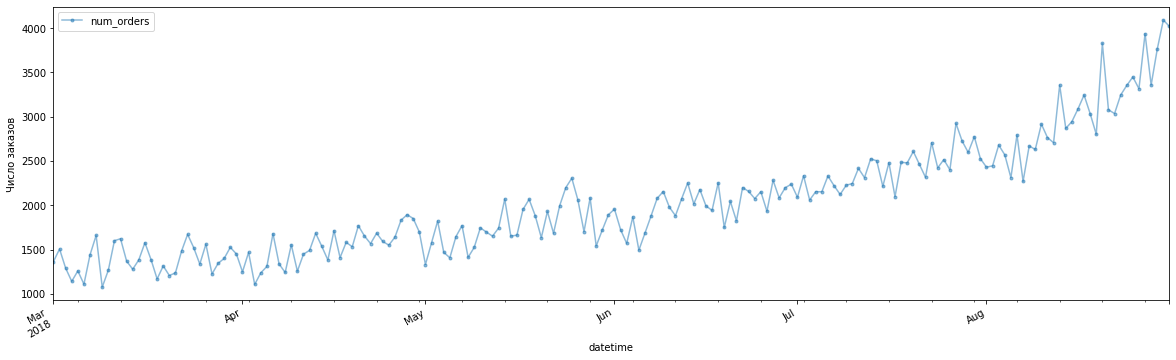

In [15]:
axes = taxi_resampled.resample('1D').sum().plot(marker = '.',alpha=0.5,linestyle=None, figsize = (20,6), subplots= True)
for ax in axes:
    ax.set_ylabel('Число заказов')

А тут уже виден тренд и он говорит об увеличении числа заказов

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [17]:
decomposed = seasonal_decompose(taxi_resampled)

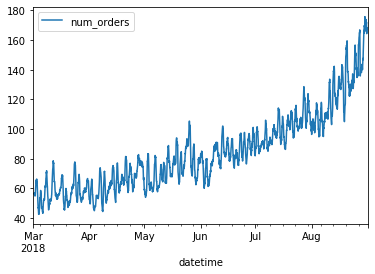

In [18]:
decomposed.trend.plot()

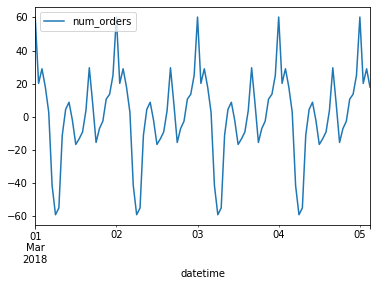

In [19]:
decomposed.seasonal[0:100].plot()

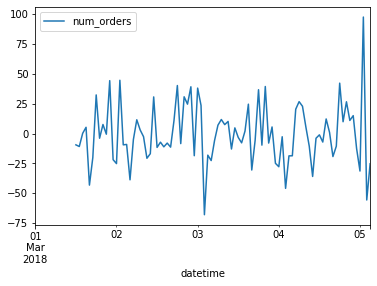

In [20]:
decomposed.resid[0:100].plot() 

Видим по тренду, что наш временной ряд нестационарен.    

In [21]:
taxi_resampled['mean_orders_1D'] = taxi_resampled['num_orders'].rolling(window = 24).mean()
taxi_resampled['std_orders_1D'] = taxi_resampled['num_orders'].rolling(window =24).std()
taxi_resampled['mean_orders_1W'] = taxi_resampled['num_orders'].rolling(window =168).mean()
taxi_resampled['std_orders_1W'] = taxi_resampled['num_orders'].rolling(window =168).std()

In [22]:
import matplotlib.dates as mdates

In [23]:
days = mdates.DayLocator() # every day
weeks = mdates.WeekdayLocator() # every week
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month

def print_trend(data, time_locator_major,time_locator_minor):
    fig, ax = plt.subplots(figsize = (20,8))
    # Просто значения
    ax.plot(data['num_orders'], marker='.', markersize=2, color='0.6',linestyle='None', label='Значения часовые')
    # Скользящее среднее дневное
    ax.plot(data['mean_orders_1D'], linewidth=2, label='Скользящее среднее дневное')
    # Скользящее среднее недельное
    ax.plot(data['mean_orders_1W'], color='0.2', linewidth=3, label='Скользящее среднее недельное')
    # Beautification of plot
    ax.xaxis.set_major_locator(time_locator_major)
    ax.xaxis.set_minor_locator(time_locator_minor)
    ax.legend()
    ax.grid(True)
    ax.set_xlabel('Время')
    ax.set_ylabel('Число заказов')
    ax.set_title('Тренд в числе заказов')

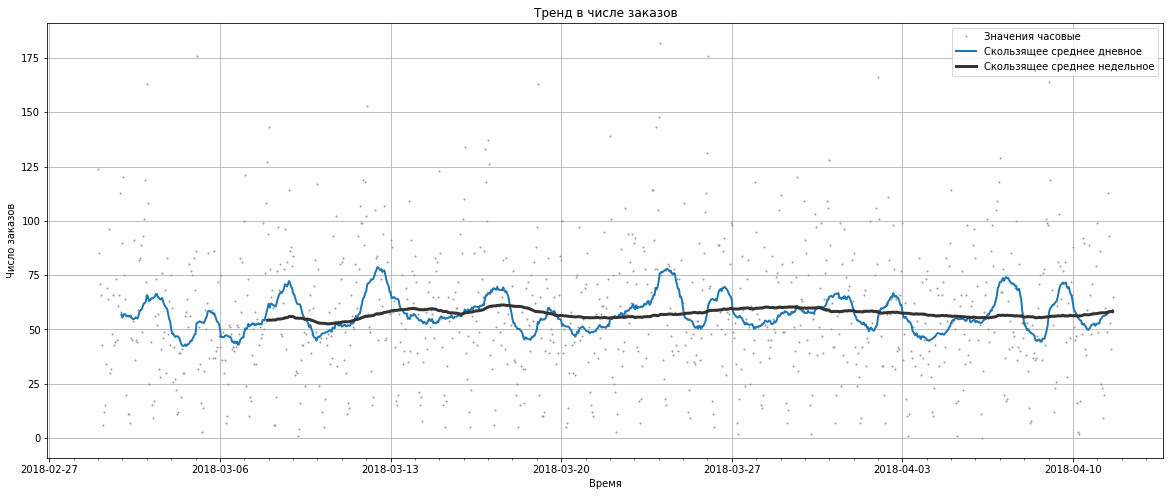

In [24]:
print_trend(taxi_resampled[0:1000],weeks,days)

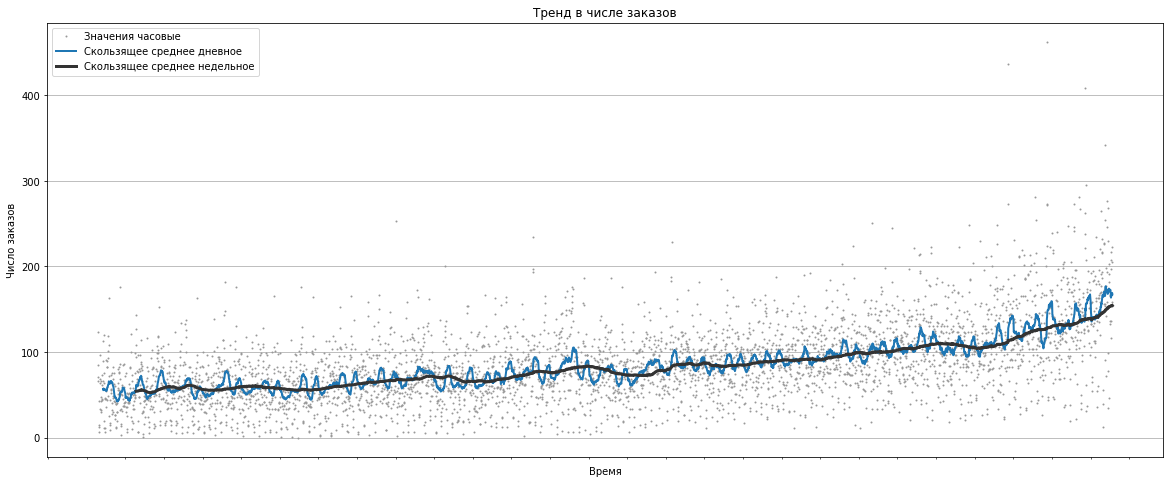

In [25]:
print_trend(taxi_resampled,years,weeks)

Наблюдается так или иначе два вида сезонностей:
- Дневная
- Недельная

Амплитуда колебаний остатков теперь гораздо меньше

## Разности временного ряда

https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1 - приятная статья по рядам и предсказаниям. Кое что беру оттуда.

Рассчитаем разность временного ряда, чтобы убрать тренд

In [26]:
# creating the first order differencing data
data_first_order_diff = taxi_resampled['num_orders'].diff()

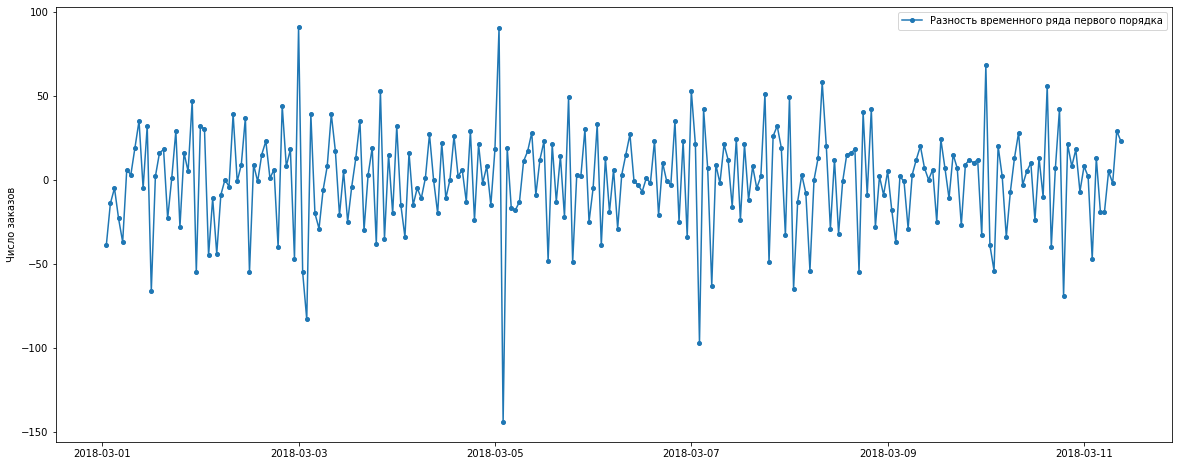

In [27]:
start, end = 0,250
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(data_first_order_diff[start:end],
marker='o', markersize=4, linestyle='-', label='Разность временного ряда первого порядка')
ax.set_ylabel('Число заказов')
ax.legend();

In [28]:
decomposed_shifted = seasonal_decompose(taxi_resampled['num_orders'].shift(fill_value=0) - taxi_resampled['num_orders'])

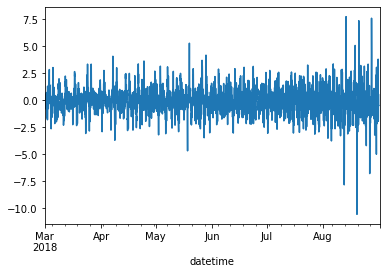

In [29]:
decomposed_shifted.trend.plot()

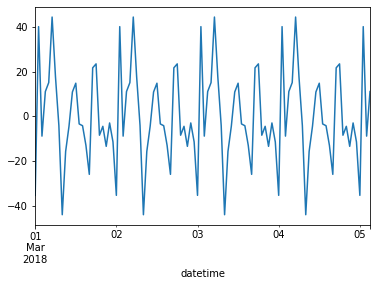

In [30]:
decomposed_shifted.seasonal[0:100].plot()

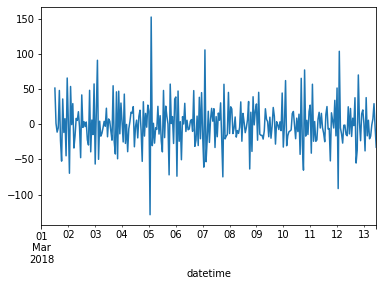

In [31]:
decomposed_shifted.resid[0:300].plot() 

Шумы значительно превосходят сезонную компоненту. 

## Автокорреляция

Техника анализа сезонности. Печатает корреляwию данных на разных временных лагах. Как пример: показывает на сколько будут похожи данные на предыдущие, если произвести сдвиг на определенное количество шагов.

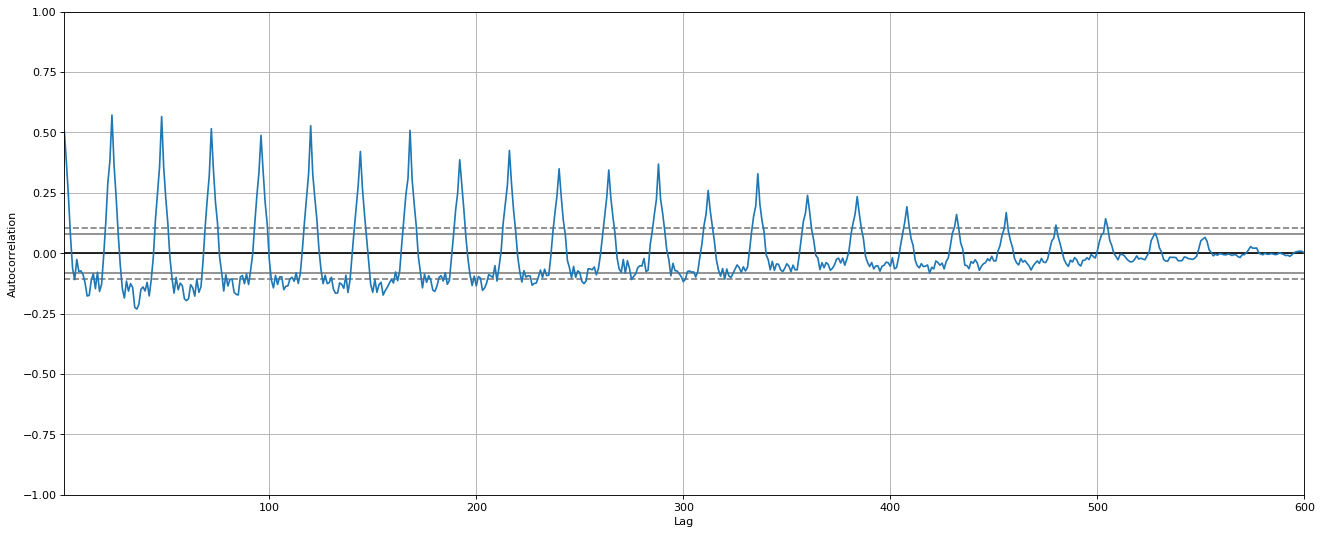

In [32]:
plt.figure(figsize=(20,8), dpi= 80)
pd.plotting.autocorrelation_plot(taxi_resampled['num_orders'][0:600])

Наблюдаемая периодичность ровно 24 часа

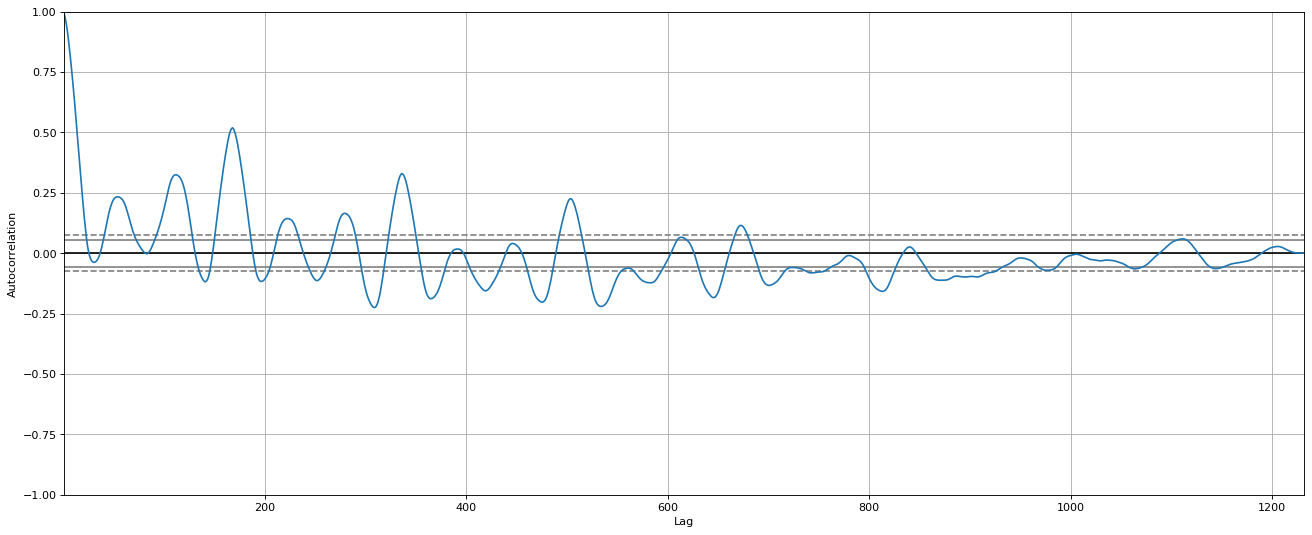

In [33]:
plt.figure(figsize = (20,8), dpi= 80)
pd.plotting.autocorrelation_plot(taxi_resampled['mean_orders_1D'][168:1400])


Есть еще некоторые корреляции в недельном формате.
Для себя еще запишу, что есть преобразования Фурье - разложение ряда на ряд гармонических колебаний: с разными амплитудами и частотами. В данном проекте я этим заниматься не буду. 

Дополним данные признаками, относящимися к времени. 

In [34]:
taxi_resampled = taxi_resampled.drop(columns=['std_orders_1D','std_orders_1W'])

In [35]:
taxi_resampled

,num_orders,mean_orders_1D,mean_orders_1W
datetime,,,
2018-03-01 00:00:00,124.0,NaN,NaN
2018-03-01 01:00:00,85.0,NaN,NaN
2018-03-01 02:00:00,71.0,NaN,NaN
2018-03-01 03:00:00,66.0,NaN,NaN
2018-03-01 04:00:00,43.0,NaN,NaN
...,...,...,...
2018-08-31 19:00:00,136.0,167.541667,154.434524
2018-08-31 20:00:00,154.0,168.041667,154.285714
2018-08-31 21:00:00,159.0,166.416667,154.244048


# 3. [Обучение](#Content) <a id='3'></a>

Итак рассмотрю несколько моделей из тех, что я читаю наиболее перспективными:
- Оценка медианой за аналогичный период
- Holt-Winters - нелинейная модель, учитывающая сезонность (не работает на юпитер-хабе)
- Линейной регрессией
- Ансамблями деревьев
- LGBMRegressor
- ElasticNet

Преобразование Бокса-Кокса: for my future consideraion. https://habr.com/ru/company/ods/blog/327242/


## 3.1 [Подготовка признаков](#Content) <a id='3.1'></a>

Следующие типы признаков будут добавлены (если еще не сделал):
1. Календарные признаки (англ. calendar features)
2. «Отстающие значения» (англ. lag features)
3. Скользящее среднее
Скользящее среднее как признак задаёт общий тренд временного ряда. 

In [36]:
taxi_features = taxi_resampled.drop(columns = ['mean_orders_1D','mean_orders_1W'])
taxi_features # набор данных, который мы будем использовать в обучении

,num_orders
datetime,
2018-03-01 00:00:00,124.0
2018-03-01 01:00:00,85.0
2018-03-01 02:00:00,71.0
2018-03-01 03:00:00,66.0
2018-03-01 04:00:00,43.0
...,...
2018-08-31 19:00:00,136.0
2018-08-31 20:00:00,154.0
2018-08-31 21:00:00,159.0


In [37]:
def make_features(data,feature_name, max_lag, rolling_mean_sizes):
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek   
    data[f'{feature_name}_shifted'] = data[feature_name].diff().shift() # находим дельту целевого признака и сдвигаем на одну позицию вперед, чтобы не было утечки
   
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data[feature_name].shift(lag)        
    for rolling_mean in rolling_mean_sizes:
        data[f'rolling_mean_{rolling_mean}'] = data[feature_name].shift().rolling(rolling_mean).mean()
    data

In [38]:
make_features(taxi_features,'num_orders', 24, [24,24*7])

In [39]:
taxi_features = taxi_features.dropna() # удаляем пропущенные значения, появившиеся из-за лагов и скользящих
taxi_features

,num_orders,hour,month,day,dayofweek,num_orders_shifted,lag_1,lag_2,lag_3,lag_4,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean_24,rolling_mean_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143.0,0,3,8,3,-33.0,94.0,127.0,108.0,76.0,...,17.0,19.0,10.0,73.0,66.0,24.0,121.0,100.0,60.041667,54.226190
2018-03-08 01:00:00,78.0,1,3,8,3,49.0,143.0,94.0,127.0,108.0,...,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,61.833333,54.339286
2018-03-08 02:00:00,65.0,2,3,8,3,-65.0,78.0,143.0,94.0,127.0,...,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,60.041667,54.297619
2018-03-08 03:00:00,68.0,3,3,8,3,-13.0,65.0,78.0,143.0,94.0,...,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,61.750000,54.261905
2018-03-08 04:00:00,60.0,4,3,8,3,3.0,68.0,65.0,78.0,143.0,...,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,61.833333,54.273810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136.0,19,8,31,4,-10.0,207.0,217.0,197.0,116.0,...,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,164.875000,154.297619
2018-08-31 20:00:00,154.0,20,8,31,4,-71.0,136.0,207.0,217.0,197.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.541667,154.434524
2018-08-31 21:00:00,159.0,21,8,31,4,18.0,154.0,136.0,207.0,217.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.041667,154.285714


In [40]:
taxi_features['num_orders'].diff().shift()

datetime
2018-03-08 00:00:00     NaN
2018-03-08 01:00:00     NaN
2018-03-08 02:00:00   -65.0
2018-03-08 03:00:00   -13.0
2018-03-08 04:00:00     3.0
                       ... 
2018-08-31 19:00:00   -10.0
2018-08-31 20:00:00   -71.0
2018-08-31 21:00:00    18.0
2018-08-31 22:00:00     5.0
2018-08-31 23:00:00    64.0
Freq: H, Name: num_orders, Length: 4248, dtype: float64

Урраа. Признаки добавлены!

## 3.2 [Разбивка на обучающую и тестовую выборки](#Content) <a id='3.2'></a>

Разделим выборку на тренировочную и тестовую. По тренировочной в дальнейшем мы постараемся провести кросс-валидацию. По тестовой мы будем проверять готовые модели, обученные на базе параметров из кросс-валидации. 

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
принято)

In [41]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(taxi_features, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-08 00:00:00 2018-08-14 06:00:00
2018-08-14 07:00:00 2018-08-31 23:00:00


Разбивка данных корректна.

## 3.3 [Метрики для оценки](#Content) <a id='3.3'></a>

В качестве метрики качества модели используем среднеквадратичное значение ошибки полученного предсказания.  

In [42]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from math import sqrt
def RMSE(y_true, y_pred):
    rmse = sqrt(mean_squared_error(y_true,y_pred))
    return rmse

rmse_score = make_scorer(RMSE, greater_is_better=False)

Функция для отображения предсказаний:

In [43]:
sum_columns = ['Модель', 'RMSE на обучающей выборке', 'RMSE на тестовой выборке']
summary = pd.DataFrame(columns = sum_columns)
def show_prediction(train, test, pred, aprox, title,summ):
    rmse = RMSE(test, pred)   
    rmse_train = RMSE(train, aprox)
    local = pd.DataFrame([[title, rmse_train, rmse]], columns=sum_columns)    
    summ = summ.append(local, ignore_index = True)
    train[-300:].plot(figsize=(36,8), fontsize=14)
    test.plot(figsize=(36,8), fontsize=14)
    pred.plot(figsize=(36,8), fontsize=14)
    if type(aprox) == pd.core.series.Series:
        aprox[-300:].plot(figsize=(36,8), fontsize=14)
    plt.title('{0}, RMSE = {1:.2f}'.format(title, rmse))
    plt.legend(loc='best')
    plt.show()
    return summ

## 3.4 [Подготовка наборов данных к кросс-валидации](#Content) <a id='3.4'></a>

Для кросс валидации нам понадобится специальный модуль sklearn, работающий с временными рядами.

In [44]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [45]:
tscv = TimeSeriesSplit(n_splits=10)

## 3.5 [Подготовка моделей](#Content) <a id='3.5'></a>

In [46]:
import scipy.stats as scs

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.api import Holt
from statsmodels.tsa.api import ExponentialSmoothing

import matplotlib.pyplot as plt
%matplotlib inline

import warnings                                 
warnings.filterwarnings('ignore')

### Оценка медианой за один сезон перед предсказанием

Создадим дамми-модель для предварительной оценки и сравнения адекватности последующих моделей
Оценку будем проводить по средним значениям последней недели.

In [47]:
pred_mean_168 = pd.Series([train['num_orders'].tail(168).mean()]*len(test), index = test.index, name = 'Naive Forecast')

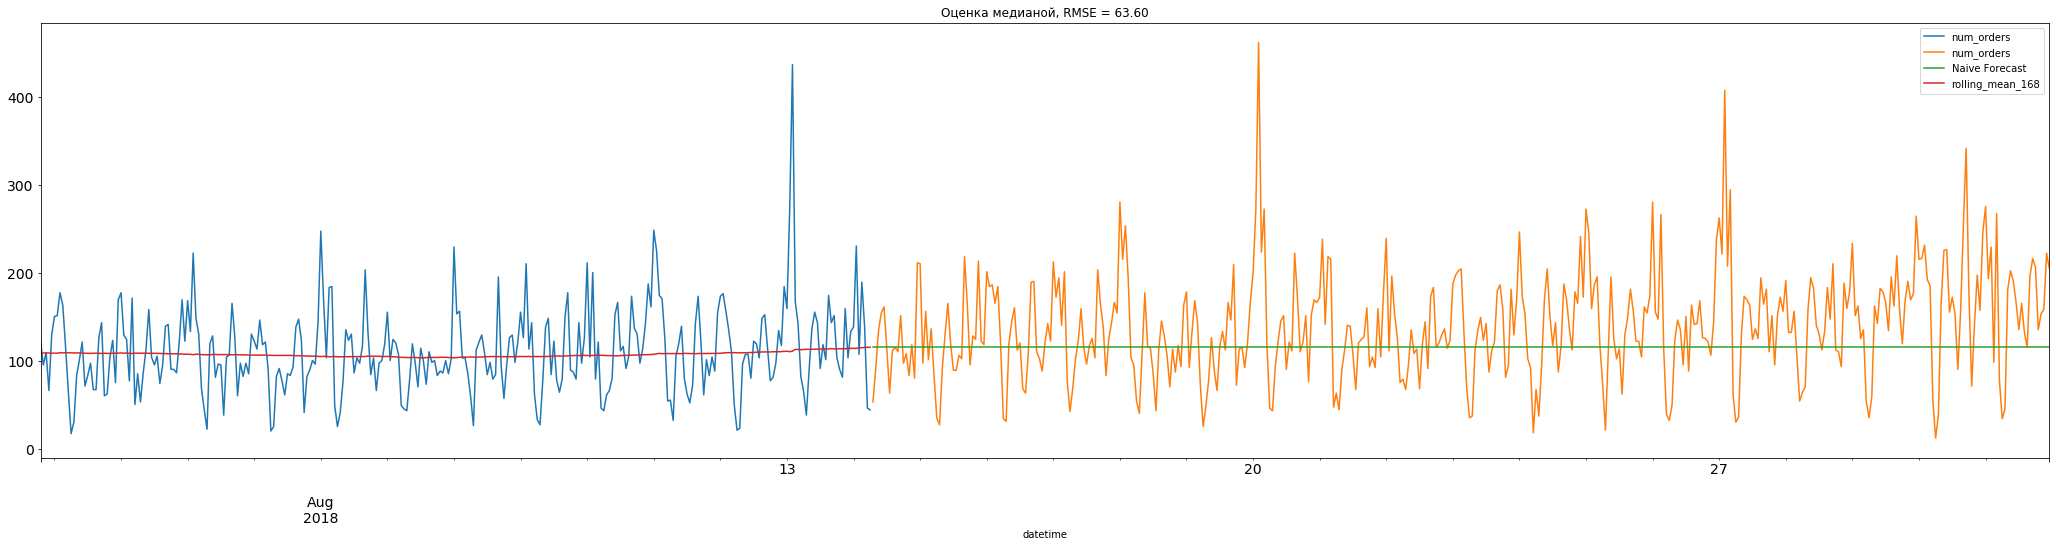

In [48]:
summary = show_prediction(train['num_orders'],test['num_orders'],pred_mean_168,train['rolling_mean_168'],'Оценка медианой',summary)

Оох. 63+ по RMSE нас явно не устроят(

### Holt-Winters: Hot linear method + seasonal

https://habr.com/ru/company/ods/blog/327242/ - общая информация взята отсюда

In [49]:

model = (ExponentialSmoothing(train['num_orders'], 
                              seasonal_periods = 24*7, 
                              trend = 'add', 
                              seasonal = 'add')
         .fit())

holt_winters = model.fittedvalues
holt_winters.name = 'Holt-Winters'

pred = model.forecast(len(test))
pred.name = 'Holt-Winters forecast'

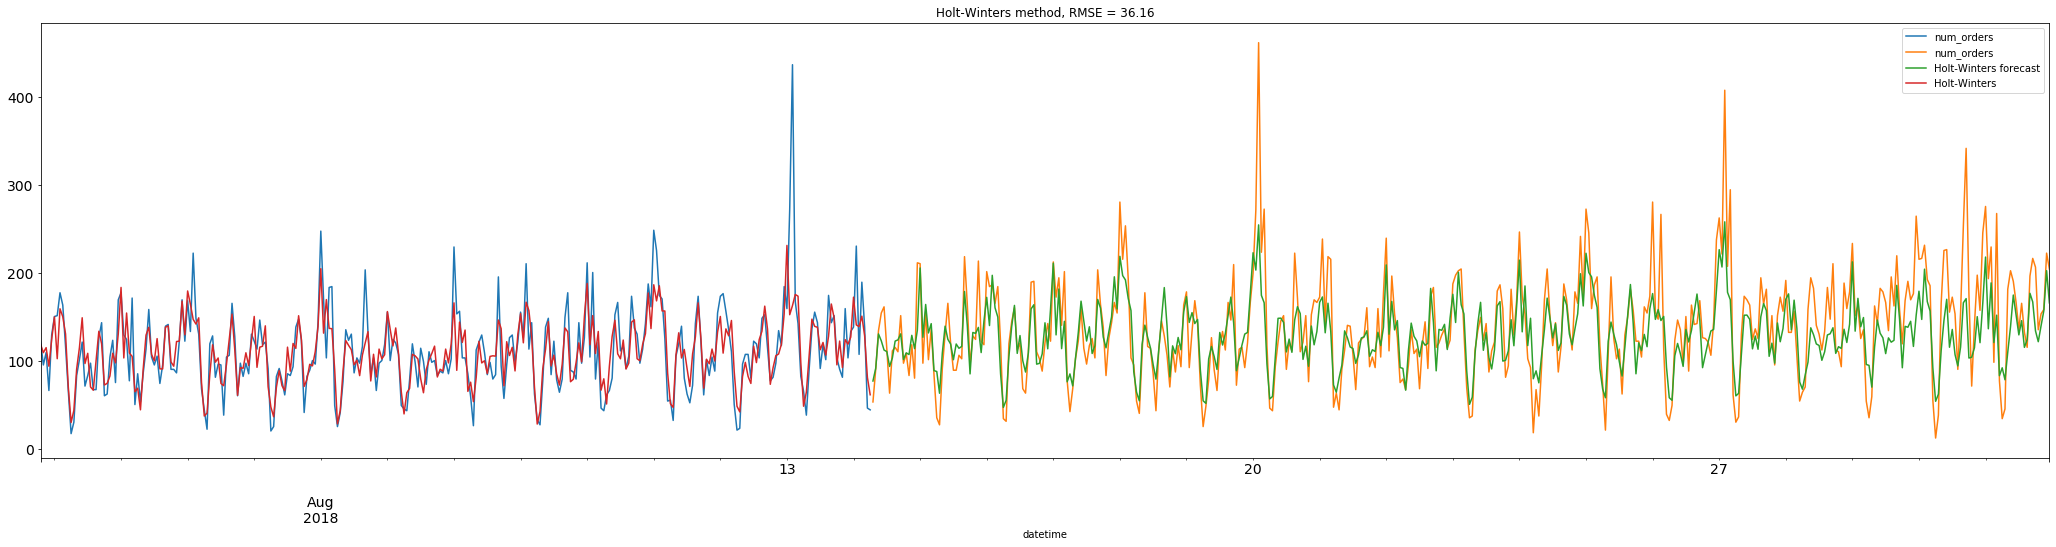

In [50]:
summary = show_prediction(train['num_orders'],test['num_orders'],pred,holt_winters,'Holt-Winters method',summary)

Урра! Получилось! __RMSE = 36.2__. Как температура у здоровй модели! Будем посмотреть, что дадут другие модели. 

### Linear regression

В тренажере не написано, но насколько понял из рассуждений на слаке предсказание строится итеративно на каждый шаг. Что-то вроде такого:

$$
prediction_n = model.predict(features(train_1...train_n,predictions_1...predictions_{n-1}))
$$


С каждым последующим шагом ошибка будет нарастать, если последующие предсказания мы делаем на основании предыдущих пресказаний. Потому всегда стоит контролировать горизонт прогнозирования. 

Судя же по требованиям проекта мы должны предсказать значение каждый раз на один шаг вперед. То есть "позади" у нас всегда проверенные данные => признаки, образованные из предыдущих показаний тоже достоверные. Конечно это уменьшит итоговую ошибку на "большом плече" предсказания.

In [51]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression(normalize=True)

In [52]:
lr_model.fit(train.drop(columns = 'num_orders'),train['num_orders'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [53]:
pred_lr_model = pd.Series(lr_model.predict(test.drop(columns = 'num_orders')), 
                          index = test.index, name = 'Linear Regression Forecast')
fitted_lr_model = pd.Series(lr_model.predict(train.drop(columns = 'num_orders')), 
                          index = train.index, name = 'Linear Regression')

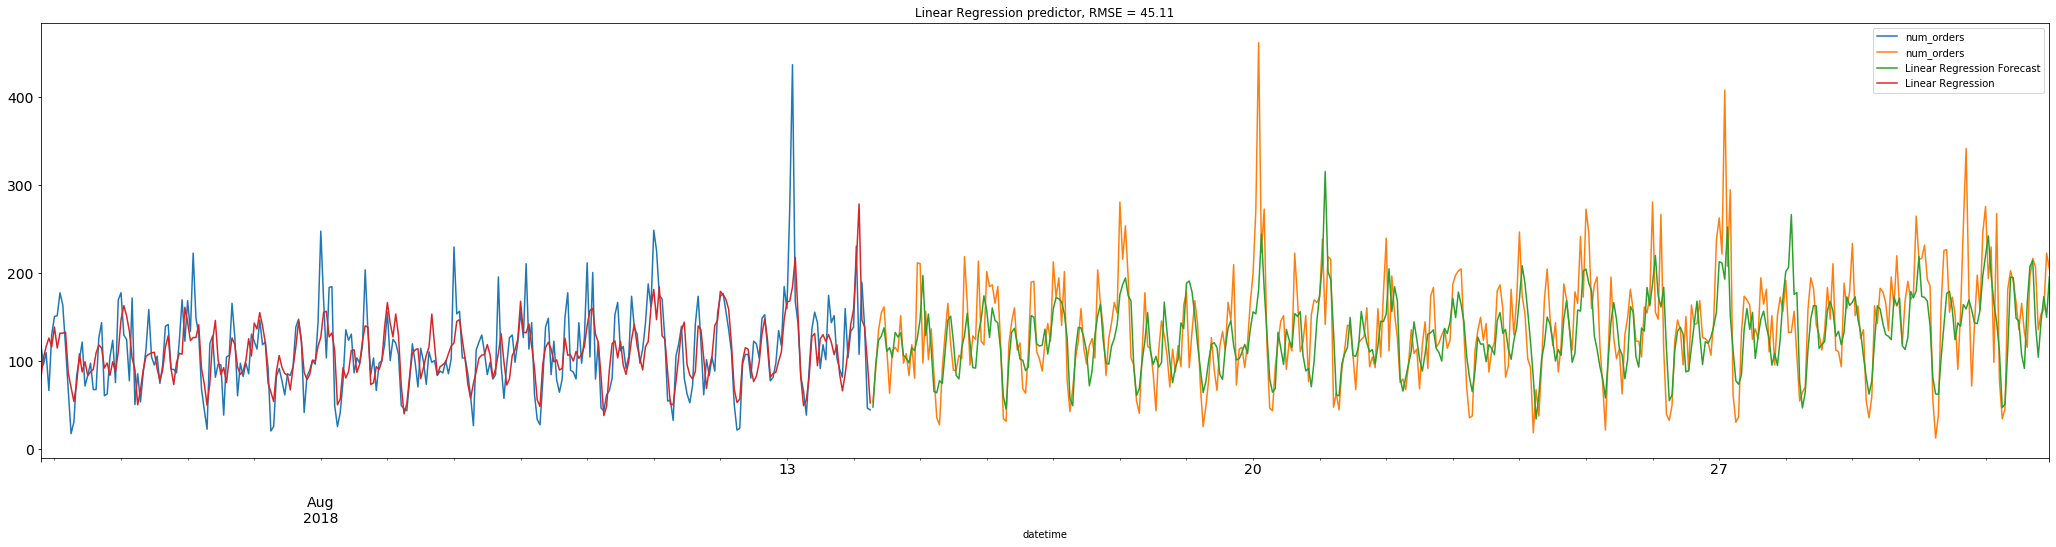

In [54]:
summary = show_prediction(train['num_orders'],
                test['num_orders'],
                pred_lr_model,
                fitted_lr_model,
                'Linear Regression predictor',
                summary)

Интересненько. Проигрывает модели Holt-Winter'а. Но 45 тоже неплохо. 

### Random Forest

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [289]:
%%time
rf_model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20,50,100,200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,16,2)]
}

tscv = TimeSeriesSplit(n_splits=9)
gsearch = GridSearchCV(estimator=rf_model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(train.drop(columns = 'num_orders'), train['num_orders'])

CPU times: user 12min 6s, sys: 1.02 s, total: 12min 7s
Wall time: 12min 16s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=9),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=No

In [290]:
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [291]:
gsearch.best_score_

-24.419626690719312

In [292]:
gsearch.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [72]:
rf_model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                                  max_features='sqrt', max_leaf_nodes=None,
                                  min_impurity_decrease=0.0, min_impurity_split=None,
                                  min_samples_leaf=1, min_samples_split=2,
                                  min_weight_fraction_leaf=0.0, n_estimators=200,
                                  n_jobs=None, oob_score=False, random_state=12345,
                                  verbose=0, warm_start=False)

rf_model.fit(train.drop(columns = 'num_orders'), train['num_orders'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [73]:
pred_rf_model = pd.Series(rf_model.predict(test.drop(columns = 'num_orders')), 
                          index = test.index, name = 'Random Forest Forecast')
fitted_rf_model = pd.Series(rf_model.predict(train.drop(columns = 'num_orders')), 
                          index = train.index, name = 'Random Forest')

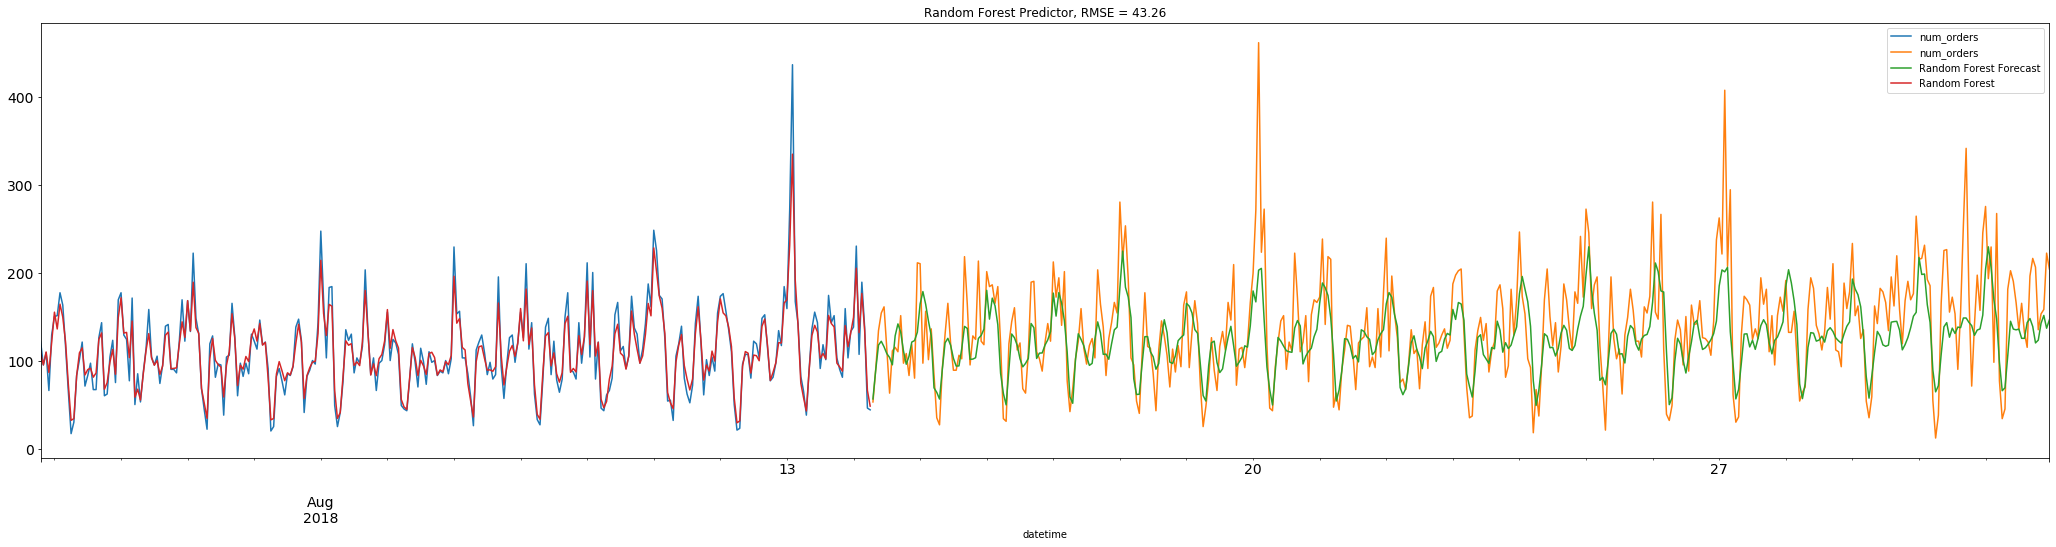

In [170]:
summary = show_prediction(train['num_orders'],
                test['num_orders'],
                pred_rf_model,
                fitted_rf_model,
                'Random Forest Predictor',
                summary)

Похоже, но не сильно лучше линейного регрессора. __RMSE__ = 43,2

### LGBMRegressor

In [56]:
from lightgbm.sklearn import LGBMRegressor

In [57]:
LGBMReg = LGBMRegressor(random_state = 12345,metric = 'rmse')
param_search = { 
    'n_estimators': [50,100,150],
    'num_leaves': [50,100,150],
    'max_depth' : [i for i in range(5,21,7)]
}

In [58]:
%%time
gsearch = GridSearchCV(estimator=LGBMReg, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(train.drop(columns = 'num_orders'), train['num_orders'])

CPU times: user 8min 29s, sys: 5.8 s, total: 8min 35s
Wall time: 8min 43s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, metric='rmse',
                                     min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves...
                                     objective=None, random_state=12345,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [5, 12, 19],
      

In [59]:
gsearch.best_score_

-24.087071251984757

In [60]:
gsearch.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=5,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=50,
              objective=None, random_state=12345, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [61]:
LGBMReg_model = gsearch.best_estimator_

In [62]:
pred_LGBMReg_model = pd.Series(LGBMReg_model.predict(test.drop(columns = 'num_orders')), 
                          index = test.index, name = 'Random Forest Forecast')
fitted_LGBMReg_model = pd.Series(LGBMReg_model.predict(train.drop(columns = 'num_orders')), 
                          index = train.index, name = 'Random Forest')

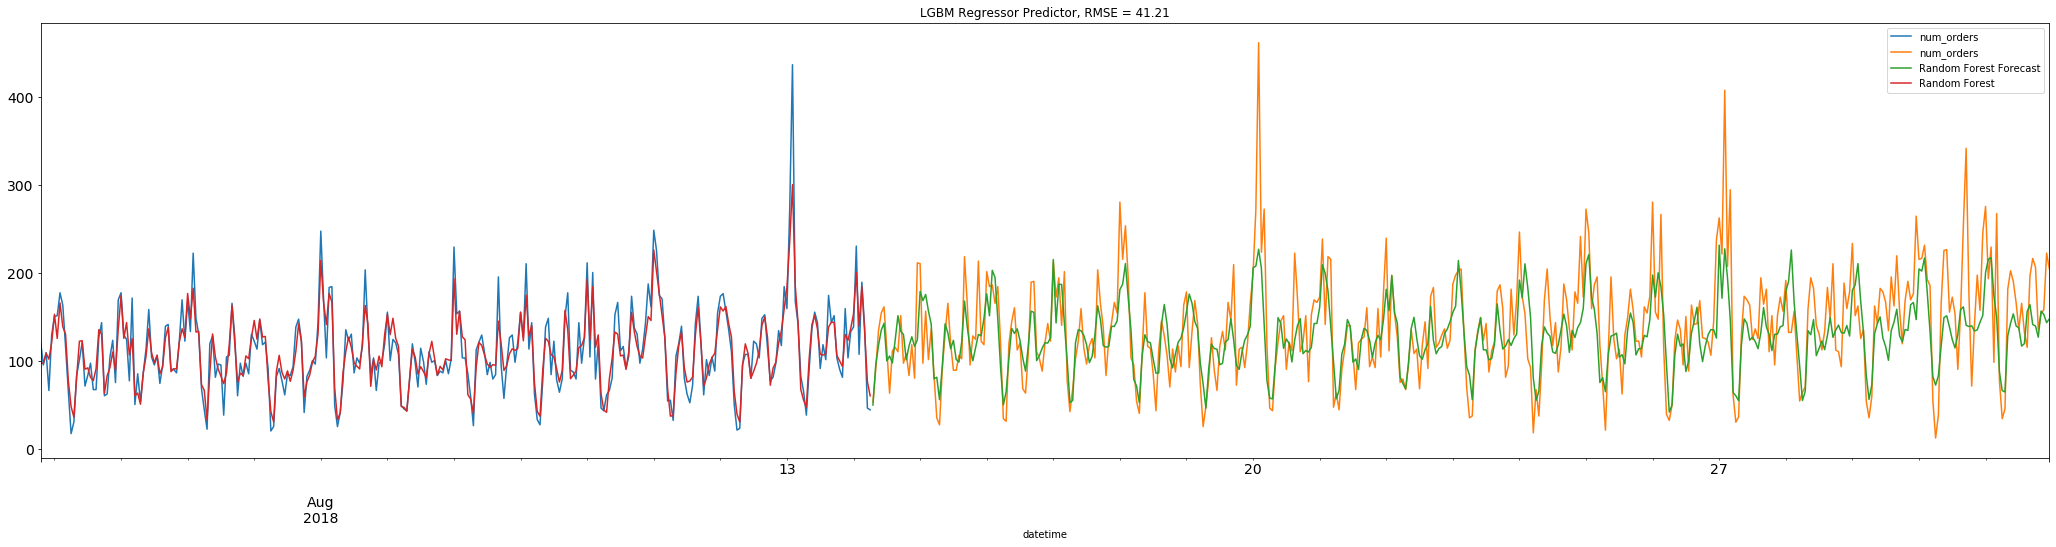

In [63]:
summary = show_prediction(train['num_orders'],
                            test['num_orders'],
                            pred_LGBMReg_model,
                            fitted_LGBMReg_model,
                            'LGBM Regressor Predictor',
                            summary)

### LGBMRegressor + HyperOpt оптимизация гиперпараметров

https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

In [64]:
from hyperopt import hp
import numpy as np

ModuleNotFoundError: No module named 'hyperopt'

In [ ]:
# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
lgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [ ]:
import lightgbm as lgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

In [ ]:
class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials
    
    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [ ]:
%%time
obj = HPOpt(train.drop(columns = 'num_orders'), 
            test.drop(columns = 'num_orders'), 
            train['num_orders'], 
            test['num_orders'])

lgb_opt = obj.process(fn_name='lgb_reg', 
                      space=lgb_para, 
                      trials=Trials(), 
                      algo=tpe.suggest, 
                      max_evals=100)

### ElasticNet

In [105]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

In [110]:
ElasticNetCV_search = ElasticNetCV(random_state = 12345,cv=tscv)

In [111]:
%%time
# gsearch = GridSearchCV(estimator=LGBMReg, cv=tscv, param_grid=param_search, scoring = rmse_score)
ElasticNetCV_search.fit(train.drop(columns = 'num_orders'), train['num_orders'])

CPU times: user 1.04 s, sys: 937 ms, total: 1.98 s
Wall time: 1.88 s


ElasticNetCV(alphas=None, copy_X=True,
             cv=TimeSeriesSplit(max_train_size=None, n_splits=10), eps=0.001,
             fit_intercept=True, l1_ratio=0.5, max_iter=1000, n_alphas=100,
             n_jobs=None, normalize=False, positive=False, precompute='auto',
             random_state=12345, selection='cyclic', tol=0.0001, verbose=0)

In [112]:
pred_ElasticNet_model = pd.Series(ElasticNetCV_search.predict(test.drop(columns = 'num_orders')), 
                          index = test.index, name = 'ElasticNet Forecast')
fitted_ElasticNet_model = pd.Series(ElasticNetCV_search.predict(train.drop(columns = 'num_orders')), 
                          index = train.index, name = 'ElasticNet')

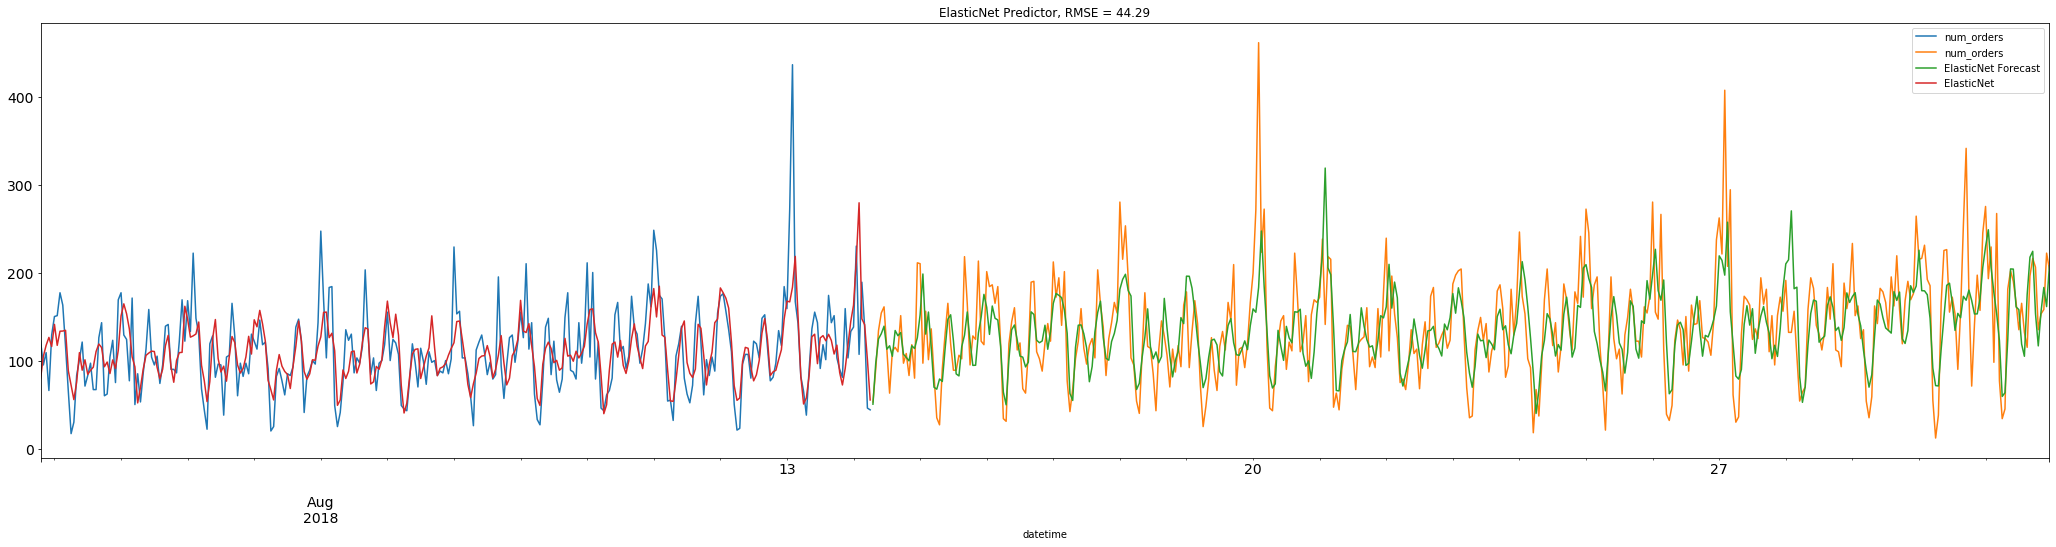

In [172]:
summary = show_prediction(train['num_orders'],
                            test['num_orders'],
                            pred_ElasticNet_model,
                            fitted_ElasticNet_model,
                            'ElasticNet Predictor',
                            summary)

Жаль, RMSE всего 44. Рассчитывал на большее

# 4. [Выводы](#Content) <a id='4'></a>

In [174]:
summary.sort_values(by = 'RMSE на тестовой выборке',ascending = True)

,Модель,RMSE на обучающей выборке,RMSE на тестовой выборке
1,Holt-Winters method,21.215831,36.155874
4,LGBM Regressor Predictor,13.242028,41.883200
3,Random Forest Predictor,9.867735,43.261978
5,ElasticNet Predictor,26.019116,44.289100
2,Linear Regression predictor,25.964898,45.108869
0,Оценка медианой,34.670042,63.599071


Отметим по результатам следующее:
- В целом все модели, кроме наивного регрессора обладают требуемым показателем точности...
- Holt-Winters method стал победителем с RMSE 36,2. Метод создан для работы с рядами, но имеет соответствующую специфику связанную с анализом ряда и настройкой параметров. На него ушло больше всего времени.
- Следующий на очереди LGBM Regressor Predictor с RMSE = 41,9 на тестовой выборке. Это закономерно, что он победил линейную регрессию, поскольку сочетает в себе преимущества двух методов: деревьев и регрессии.
- Оставшиеся модели более-менее одинаковы с точки зрения результатов. Наивный метод конечно же проигрывает
- Отдельно отмечу, что мои деревья чересчур хорошо предсказывают обучающую выборку - произошло переобучение модели. Конечно такую в продакшн пускать не стоит.